# **Analyse des tendances de prix des ordinateurs portables sur eBay**

### **Introduction**


Notre projet vise à étudier les tendances de consommation des utilisateurs de plateformes de e-commerce, en se concentrant sur les ordinateurs portables sur eBay. Les questions centrales de cette étude sont les suivantes :
- Quels sont les facteurs qui influencent la demande d’un produit et, par conséquent, son prix ?
- Comment estimer le prix d’un ordinateur en fonction de ses caractéristiques ?

Pour y répondre, nous avons distingué deux types de critères :

**Critères objectifs :** RAM, stockage, densité de pixels, condition de l’article, taille de l'écran.

**Critères subjectifs :** marque ou couleur.

Nous jugeons que ces critères sont suffisants pour évaluer la qualité d'un ordinateur. En particulier, la RAM se trouve être un bon proxy de la puissance d'un ordinateur car une grande capacité de mémoire vive est souvent associée à d’autres composants haut de gamme. Les fabricants équipent généralement les ordinateurs dotés de beaucoup de RAM avec des processeurs rapides, des disques SSD performants et des cartes graphiques puissantes, ce qui en fait un signal fiable d'une configuration globale de qualité.

Nous avons trouvé le choix de la plateforme eBay pertinent dans la mesure où ce sont les utilisateurs qui fixent le prix qu'ils attribuent à leur ordinateur. Cette dynamique permet d’évaluer si les vendeurs sont objectifs dans leur valorisation du produit ou si le prix fixé est cohérent avec les caractéristiques de l’ordinateur. Grâce aux tendances observées, il devient possible de déterminer si ces prix reflètent réellement la valeur des produits.

Afin d’analyser ces influences, nous avons choisi de modéliser la relation entre les caractéristiques des produits et leur prix à l’aide d’une régression linéaire. Cette approche permet de quantifier l’impact de chaque critère sur le prix des ordinateurs portables. Nous pourrons ainsi mieux comprendre comment les utilisateurs déterminent le prix de vente de leurs ordinateurs portables et savoir si certaines variables les influencent plus que d'autres. 


## **1. Installation**

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aiohttp
import asyncio
import re 

## **2. Chargement des données dans le projet**

### **2.1 Données eBay**

En raison du temps de réponse élevé de l’API et du nombre d'appels à l'API limité à 4500 par jour, nous avons préféré exécuter les requêtes en amont et sauvegarder les données dans un fichier CSV. Cette démarche a pour objectif de faciliter l’analyse en évitant les délais d’attente liés à l’API et en permettant d'avoir plus de données. 

Le code permettant de collecter les données est disponible sur le GitHub du projet. Ce script **data.py** situé dans le fichier **src** peut être exécuté en suivant les instructions du README pour l'accès à l'API si de nouvelles données doivent être extraites.

Dans le notebook, nous nous contentons de charger le fichier CSV prégénéré pour effectuer les étapes d’analyse et de nettoyage.

Cette approche permet une expérience plus fluide et garantit la reproductibilité de l’étude sans dépendre des performances de l’API au moment de l’exécution.



### **Récupération des données**

Pour collecter les données nécessaires à notre étude, nous avons utilisé l’API Browse d’eBay. Ce choix s’explique par la richesse des informations disponibles sur cette plateforme et son large catalogue de produits. Cependant, cela a requis plusieurs étapes préparatoires :

1. **Choix d'un segment spécifique :** Pour limiter la variabilité des données, nous avons choisi de nous concentrer sur les ordinateurs portables. Ce segment présente de nombreuses spécificités (RAM, stockage, écran, etc.) qui permettent d’étudier l’impact de chaque critère sur le prix.

2. **Délimitation du marché :** Nous avons choisi de nous focaliser sur le marché français. Cette décision a pour but d’éviter les biais liés à des contextes géopolitiques différents entre les marchés ou à des devises différentes. 

3. **Extraction des données :**
Les informations classiques comme le prix et l’état des articles sont directement accessibles via l’API Browse pour chaque item.
Les caractéristiques plus précises (RAM, marque, stockage, taille de l’écran) sont stockées dans une sous-catégorie nommée localized aspects. Ces informations sont organisées sous forme de dictionnaire (clé/valeur).

4. **Gestion des données manquantes :**
Comme les utilisateurs remplissent eux-mêmes les informations, certaines données sont parfois absentes. 
Plusieurs approches ont été envisagées :
- Exclure les articles avec des données manquantes, en raison du volume important de données disponibles.
- Conserver les articles incomplets pour ne pas réduire excessivement l’échantillon.

Afin de ne pas trop réduire l'échantillon ou de compromettre la fiabilité de l'étude nous avons choisi de conserver les articles ayant obligatoirement les informations suivantes : prix, capacité de stockage, RAM et marque. Toutefois, si des données telles que la taille de l'écran, la résolution ou encore la date de publication ne sont pas présentes il ne nous semblait pas pertinent d'enlever ces ordinateurs portables puisque cela ne compromet pas le résultat de notre étude et nous permet d'avoir un échantillon plus important.

In [1]:
from src.utils import load_data

ordi_csv = "data3.csv"
df = load_data(ordi_csv)

### **2.2 Données issues de scrapping**

Dès le début du projet, nous avons supposé que la popularité de la marque influencerait les résultats. Il nous a donc semblé pertinent de rechercher des classements de popularité des marques high-tech sur le marché. Pour ce faire, nous avons procédé à un processus de scraping afin d'obtenir un classement moyen à partir de plusieurs sites internet.

Nous avons développé un script de scraping permettant d’attribuer à chaque marque un classement de popularité, intégré dans une colonne intitulée ‘Rang’ du DataFrame. Ce rang a été calculé à partir des classements de six sites web figurant parmi les premiers résultats d’une recherche sur les “classements des ordinateurs”. En combinant ces différentes sources, nous avons effectué une moyenne pour déterminer le rang final de chaque marque, que nous avons ensuite ajouté à la colonne correspondante. Les différents sites sont : 
- Le Parisien
- LaptopSpirit
- GeekWise
- FormationMax
- Test-Achats
- ApprendreInformatique

In [2]:
from src.scraping import get_rang
df = get_rang(df)
df.head()

,ID,Prix,Condition,RAM,Stockage,Marque,Couleur,Taille écran,Résolution,Date de publication,Rang,Coefficient
0,v1|176737201854|0,1680.0,Occasion,16 Go,0,ASUS,NaN,"13,4""",NaN,2024-12-15T17:33:06.000Z,1,0.0
1,v1|375863586836|0,550.0,Occasion,8 Go,256 Go,Apple,Gris,"13""",2560 x 1600,2024-12-13T08:42:48.000Z,3,4.5
2,v1|146269671817|0,120.0,Occasion,6 Go,700Go,ASUS,Rouge,"15,6""",NaN,2024-12-15T11:51:11.000Z,1,0.0
3,v1|196898961056|0,89.9,Occasion,8 Go,480Go,HP,NaN,"17,3""",NaN,2024-12-17T16:37:02.000Z,5,0.0
4,v1|365291982473|0,1300.0,Occasion,16 Go,256 Go,Dell,Noir,"13""",1920 x 1080,2024-12-17T16:57:08.000Z,9,1.0


Dans un second temps, nous avons jugé pertinent de mesurer la popularité des articles présents sur le site eBay. Pour cela, nous avons défini un coefficient de popularité construit à partir des informations suivantes, obtenues grâce au scraping :

- **Want :** Nombre de personnes actuellement intéressées par l’article (le consultent activement).
- **Watched :** Nombre de personnes ayant vu l’article au cours des dernières 24 heures.
- **Watchlist :** Nombre de personnes ayant ajouté l’article à leur liste de surveillance.
- **Sold :** Nombre d’exemplaires déjà vendus de cet article.

$$
\text{Coefficient de popularité}= \frac{{\text{Watched} + 2*\text{Want} + 3*\text{Sold} + 2*\text{Watchlist}}}{8}
$$

Le code suivant peut prendre un certain temps pour tourner en raison du nombre conséquent de données et donc de recours au scrapping. Ainsi, nous avons choisi d'appliquer le code par groupe de 100 articles. 

In [5]:
import nest_asyncio
nest_asyncio.apply()

from src.scraping import get_coefficient
get_coefficient(df, 100)
df.head()

Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 43...
Processing batch 44.

,ID,Prix,Condition,RAM,Stockage,Marque,Couleur,Taille écran,Résolution,Date de publication,Rang,Coefficient
0,v1|176737201854|0,1680.0,Occasion,16 Go,0,ASUS,NaN,"13,4""",NaN,2024-12-15T17:33:06.000Z,1,0.0
1,v1|375863586836|0,550.0,Occasion,8 Go,256 Go,Apple,Gris,"13""",2560 x 1600,2024-12-13T08:42:48.000Z,3,4.5
2,v1|146269671817|0,120.0,Occasion,6 Go,700Go,ASUS,Rouge,"15,6""",NaN,2024-12-15T11:51:11.000Z,1,0.0
3,v1|196898961056|0,89.9,Occasion,8 Go,480Go,HP,NaN,"17,3""",NaN,2024-12-17T16:37:02.000Z,5,0.0
4,v1|365291982473|0,1300.0,Occasion,16 Go,256 Go,Dell,Noir,"13""",1920 x 1080,2024-12-17T16:57:08.000Z,9,1.0


## **3. Nettoyage des données**

Comme évoqué plus tôt, la particularité des données récoltées est qu'elles ont été entrées par les vendeurs eux-mêmes via la plateforme. Ainsi, si le nom de la catégorie (ex: 'RAM', 'Stockage') est le même pour chaque produit, les informations contenues dans chaque colonne différent dans leur format. Par défaut, toutes les données sont de type "object" ce qui ne les rend pas exploitable directement pour nous. Le travail de nettoyage est ainsi essentiel afin d'avancer sur notre projet.  

1) **Nettoyage des données chiffrées**

Pour cela, nous avons créé une fonction **extract_float_from_object** au sein du fichier **utils.py** qui permet d'extraire un nombre de type float à partir d'une chaîne de caractère. Nous pouvons appliquer cette fonction directement pour la catégorie 'Taille écran'.

In [3]:
from src.utils import extract_float_from_object, extract_storage

df['Taille écran'] = df['Taille écran'].apply(extract_float_from_object)

Pour gérer les catégories liées au stockage dont les données étaient soit rentrées en Go, soit en To, nous avons créé une seconde fonction dérivée de la première, mais qui effectue la conversion en Go pour les données entrées en To, selon la formule **1To = 1024Go**.

In [4]:
df['RAM'] = df['RAM'].apply(extract_storage)
df['Stockage'] = df['Stockage'].apply(extract_storage)

Ensuite, pour gérer la colonne résolution dont le format est le suivant : **Largeur x Hauteur'**, nous avons choisi de combiner cette information avec la taille de l'écran pour établir une mesure comparable entre tous les ordinateurs du data frame : la densité de pixels (PPI).

$$
Densité\ de\ pixels = \frac{\sqrt{\text{largeur}^2 + \text{hauteur}^2}}{\text{taille de l'écran en pouces}}
$$

On commence par extraire la largeur et la hauteur dans deux nouvelles colonnes, et on utilise ensuite la formule ci-dessus pour créer la colonne **PPI** que l'on conservera.

In [7]:
#Extraction de la résolution dans deux nouvelles colonnes
df[['Largeur', 'Hauteur']] = df['Résolution'].str.extract(r'(\d+)[\s]*[xX][\s]*(\d+)', expand=True)
df[['Largeur', 'Hauteur']] = df[['Largeur', 'Hauteur']].apply(pd.to_numeric, errors='coerce')

#Calcul du PPI
df['Taille écran'] = df['Taille écran'].apply(extract_float_from_object)
df[['Largeur', 'Hauteur', 'Taille écran']] = df[['Largeur', 'Hauteur', 'Taille écran']].replace(0, np.nan)
# On calcule le PPI uniquement pour les lignes où toutes les valeurs nécessaires sont présentes
mask = df[['Largeur', 'Hauteur', 'Taille écran']].notnull().all(axis=1)
df.loc[mask, 'PPI'] = np.round(np.sqrt(df.loc[mask, 'Largeur']**2 + df.loc[mask, 'Hauteur']**2) / df.loc[mask, 'Taille écran'])

2. **Nettoyage des données temporelles**

Cela concerne uniquement la colonne **Date de publication**. Ici, le format est idéal car c'est une information qui nous est fournie directement par eBay. On utilise alors la fonction intégrée à pandas **pd.to_datetime()**

In [8]:
df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')

3. **Nettoyage des données textuelles**

Cela concerne les colonnes **Condition**, **Marque** et **Couleur**. Ici, l'enjeu est d'uniformiser les données afin de rassembler toutes les données identiques de fait mais rentrées différemment par les utilisateurs. 

In [9]:
#Normalisation des couleurs
def normalize_color(color):
    if isinstance(color, str):
        color = color.lower()
        if 'gris' in color or 'silver' in color or 'argent' in color or 'argenté' in color or 'grey' in color and 'graphite' in color:
            return 'gris'
        elif 'noir' in color or 'black' in color:
            return 'noir'
        elif 'blanc' in color or 'white' in color:
            return 'blanc'
        elif 'bleu' in color or 'midnight' in color or 'blue' in color:
            return 'bleu'
        elif 'rouge' in color or 'red' in color:
            return 'rouge'
        elif 'vert' in color or 'green' in color:
            return 'vert'
        elif 'jaune' in color or 'yellow' in color:
            return 'jaune'
        elif 'rose' in color or 'pink' in color:
            return 'rose'
        elif 'marron' in color or 'brown' in color:
            return 'marron'
        elif 'violet' in color or 'purple' in color:
            return 'violet'
    return "autre"

df['Couleur'] = df['Couleur'].apply(normalize_color)

#Normalisation des conditions 
def convertir_condition(condition):
    """ 
    Crée une classification des conditions des produits du meilleur au pire
    """
    if isinstance(condition, str):
        if "Neuf" in condition:
            return "Neuf"
        elif "Ouvert (jamais utilisé)" in condition:
            return "Ouvert"
        elif 'Parfait état - Reconditionné' in condition: 
            return "Parfait état"
        elif 'Très bon état - Reconditionné' in condition:
            return "Très bon état"
        elif 'État correct - Reconditionné' in condition:
            return "État correct"
        elif 'Occasion' in condition: 
            return "Occasion"
    
df['Condition'] = df['Condition'].apply(convertir_condition)

#Normalisation des marques
def format_marque(marque):
    if isinstance(marque, str):
        marque = marque.lower()
        if any(substring in marque for substring in ['carte graphique', 'nvidia']):
            return np.nan #Ici, on élimine également les lignes qui ne correspondent 
                          #pas à des ordinateurs portables, rentrées par erreur
        elif 'apple' in marque or 'macbook' in marque or 'APPLE'in marque :
            return 'Apple'
        elif 'dell' in marque or 'del' in marque or 'DELL' in marque:
            return 'Dell'
        elif 'hp' in marque:
            return 'HP'
        elif 'lenovo' in marque:
            return 'Lenovo'
        elif 'asus' in marque:
            return 'Asus'
        elif 'acer' in marque:
            return 'Acer'
        elif 'samsung' in marque:
            return 'Samsung'
        elif 'sony' in marque:
            return 'Sony'
        elif 'toshiba' in marque:
            return 'Toshiba'
        elif 'huawei' in marque:
            return 'Huawei'
        elif 'msi' in marque:
            return 'MSI'
        elif 'panasonic' in marque:
            return 'Panasonic'
        elif 'microsoft' in marque:
            return 'Microsoft'
        elif 'lg' in marque:
            return 'LG'
        elif 'google' in marque:
            return 'Google'
        elif 'alienware' in marque:
            return 'Alienware'
        elif 'razer' in marque:
            return 'Razer'
        elif 'gigabyte' in marque:
            return 'Gigabyte'
        elif 'clevo' in marque:
            return 'Clevo'
        elif 'fujitsu' in marque:
            return 'Fujitsu'
        elif 'medion' in marque:
            return 'Medion'
        elif 'xmg' in marque:
            return 'XMG'
        elif 'chuwi' in marque:
            return 'Chuwi'
        elif 'jumper' in marque:
            return 'Jumper'
        elif 'teclast' in marque:
            return 'Teclast'
        elif 'voyo' in marque:
            return 'Voyo'
        elif 'bmax' in marque:
            return 'BMAX'
        elif 'one-netbook' in marque:
            return 'One-Netbook'
        elif 'gpd' in marque:
            return 'GPD'
        elif 'tuxedo' in marque:
            return 'Tuxedo'
        elif 'system76' in marque:
            return 'System76'
        elif 'purism' in marque:
            return 'Purism'
        elif 'pine64' in marque:
            return 'Pine64'
        elif 'minisforum' in marque:
            return 'Minisforum'
        elif 'azulle' in marque:
            return 'Azulle'
        elif 'beelink' in marque:
            return 'Beelink'
        elif 'meego' in marque:
            return 'Meego'
        elif 'vorke' in marque:
            return 'Vorke'
        elif 'trigkey' in marque:
            return 'Trigkey'
        elif 'acepc' in marque:
            return 'ACEPC'
        elif 'awow' in marque:
            return 'AWOW'
        elif 'niuniutab' in marque:
            return 'Niuniutab'
        else:
            return np.nan
    return np.nan


df['Marque'] = df['Marque'].apply(format_marque)
df = df.dropna(subset=['Marque'])


On se débarasse des colonnes qui nous seront inutiles pour la suite


In [10]:
df = df.drop(['Largeur', 'Hauteur', 'Résolution'], axis=1)
#la colonne résolution est remplacée par la colonne PPI qui compile taille de l'écran et résolution

Pour obtenir notre data frame final, il reste encore à gérer les valeurs aberrantes qui sont assez fréquentes du fait des erreurs ou mauvais choix des utilisateurs eBay.

4. **Gestion des valeurs aberrantes**

Un bon outil pour repérer les valeurs aberrantes est la boîte à moustache qui nous donne une vision claire de la répartition des données pour chaque catégorie. On peut la générer pour chaque colonne grâce à la fonction suivante:

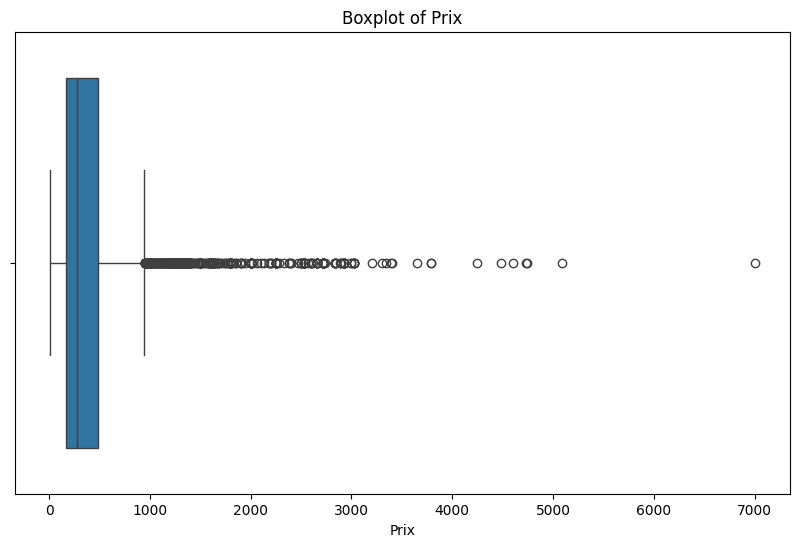

In [11]:
def boxplot(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column_name])
    plt.title(f'Boxplot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

boxplot(df, 'Prix')
#boxplot(df, 'Stockage')
#boxplot(df, 'RAM')
#boxplot(df, 'PPI')
#boxplot(df, 'Taille écran')

Grâce à ces boites à moustache ainsi qu'un peu de logique, on établit une plage cohérente pour chaque colonne. Toute donnée à l'extérieur de ces plages est considérée comme "aberrante" et est gérée en fonction. 

**Caractéristiques des plages** :

- **Plage des prix** : $[50\ € ;\ 3000\ €]$
- **Plage de la densité de pixels** : $[80\ \text{PPI} ;\ 300\ \text{PPI}]$
- **Plage de la capacité de stockage** : $[32\ \text{Go} ;\ 4000\ \text{Go}]$
- **Plage de la capacité de RAM** : $[2\ \text{Go} ;\ 64\ \text{Go}]$
- **Plage de la taille d’écran** : $[6'' ;\ 20'']$


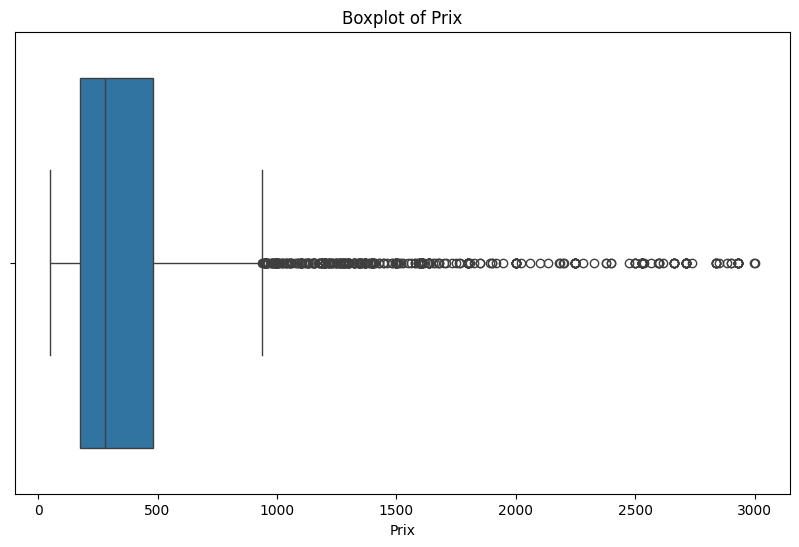

In [12]:
df = df[(df['Prix'] >= 50) & (df['Prix'] <= 3000)]  
df.loc[(df['PPI'] > 300) | (df['PPI'] < 80), 'PPI'] = np.nan
# énormément de gens se trompent en mettant la même valeur pour la RAM et le stockage
df.loc[(df['Stockage'] < 32) | (df['Stockage'] > 4000), 'Stockage'] = np.nan  
df.loc[(df['RAM'] < 2) | (df['RAM'] > 64), 'RAM'] = np.nan  
df.loc[(df['Taille écran'] < 6) | (df['Taille écran'] > 20), 'Taille écran'] = np.nan  

boxplot(df, 'Prix')


Etant donné que l'on cherche à estimer le prix, on a décidé de supprimer les lignes où les prix étaient aberrants. Pour les autres variables, on a décidé de les remplacer par des **NaN** pour les exclure de la visualisation sans se priver de l'information que nous apporte les autres données de cet ordinateur.

Notre data frame est à présent nettoyé, nous allons pouvoir commencer à l'analyser.

In [13]:
df.head(10)

,ID,Prix,Condition,RAM,Stockage,Marque,Couleur,Taille écran,Date de publication,Rang,Coefficient,PPI
0,v1|176737201854|0,1680.0,Occasion,16.0,NaN,Asus,autre,13.4,2024-12-15 17:33:06+00:00,1,0.00,NaN
1,v1|375863586836|0,550.0,Occasion,8.0,256.0,Apple,gris,13.0,2024-12-13 08:42:48+00:00,3,4.50,232.0
2,v1|146269671817|0,120.0,Occasion,6.0,700.0,Asus,rouge,15.6,2024-12-15 11:51:11+00:00,1,0.00,NaN
3,v1|196898961056|0,89.9,Occasion,8.0,480.0,HP,autre,17.3,2024-12-17 16:37:02+00:00,5,0.00,NaN
4,v1|365291982473|0,1300.0,Occasion,16.0,256.0,Dell,noir,13.0,2024-12-17 16:57:08+00:00,9,1.00,169.0
5,v1|235873614482|0,75.0,Occasion,4.0,64.0,HP,blanc,14.1,2024-12-16 18:07:16+00:00,5,0.00,111.0
6,v1|226501515887|0,230.0,Occasion,8.0,128.0,Asus,autre,14.0,2024-12-17 21:45:30+00:00,1,0.00,NaN
7,v1|326373954761|0,340.0,Ouvert,16.0,256.0,Dell,gris,14.0,2024-12-16 19:12:19+00:00,9,0.00,157.0
9,v1|196734278702|0,169.0,Très bon état,8.0,620.0,Panasonic,noir,12.0,2024-10-19 09:22:26+00:00,0,7.12,NaN
10,v1|286214085403|0,80.0,Occasion,8.0,256.0,Lenovo,noir,14.0,2024-12-13 23:59:37+00:00,8,0.00,NaN


## **4. Visualisation**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4280 entries, 0 to 4550
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   ID                   4280 non-null   object             
 1   Prix                 4280 non-null   float64            
 2   Condition            4277 non-null   object             
 3   RAM                  4039 non-null   float64            
 4   Stockage             3927 non-null   float64            
 5   Marque               4280 non-null   object             
 6   Couleur              4280 non-null   object             
 7   Taille écran         3942 non-null   float64            
 8   Date de publication  4280 non-null   datetime64[ns, UTC]
 9   Rang                 4280 non-null   int64              
 10  Coefficient          4280 non-null   float64            
 11  PPI                  2262 non-null   float64            
dtypes: datetime64[ns, UTC](1)

On remarque que beaucoup de valeurs sont manquantes pour la densité de pixels. Nous considérons cependant que le nombre d'observations demeure assez élevé pour identifier son effet sur les prix. 
De manière générale, nous faisons l'hypothèse que les valeurs manquantes ne reflète pas un biais car elles sont issues des informations entrées par les vendeurs indépendants qui peuvent vendre n'importe quel type d'ordinateurs. 

In [15]:
df.describe()

,Prix,RAM,Stockage,Taille écran,Rang,Coefficient,PPI
count,4280.000000,4039.000000,3927.000000,3942.000000,4280.000000,4280.000000,2262.000000
mean,432.746086,11.305026,409.815146,14.293257,5.228505,0.526612,149.351901
std,464.323130,8.502894,292.764988,1.606300,3.136101,1.554739,41.287409
min,50.000000,2.000000,32.000000,6.000000,0.000000,0.000000,82.000000
25%,175.000000,8.000000,256.000000,13.300000,3.000000,0.000000,116.000000
50%,279.000000,8.000000,256.000000,14.000000,5.000000,0.000000,141.000000
75%,480.000000,16.000000,512.000000,15.600000,8.000000,0.500000,157.000000
max,3000.000000,64.000000,2048.000000,20.000000,10.000000,43.750000,294.000000


Nous pouvons pour commencer analyser les distributions de prix. 

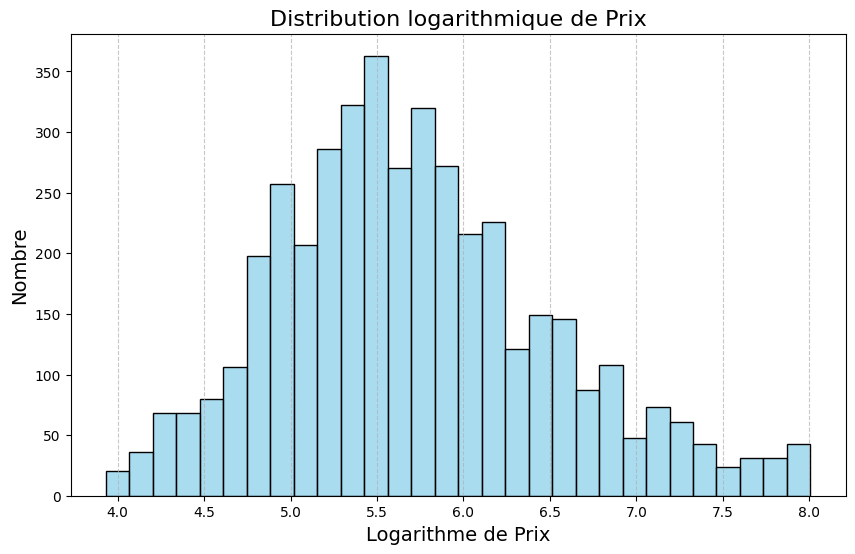

In [16]:
def plot_log_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column].apply(lambda x: np.log(x + 1)), bins=30, color='skyblue', kde=False, alpha=0.7)
    plt.title(f"Distribution logarithmique de {column}", fontsize=16)
    plt.xlabel(f"Logarithme de {column}", fontsize=14)
    plt.ylabel("Nombre", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


plot_log_distribution(df,'Prix')

Le graphique représente la distribution logarithmique des prix des ordinateurs portables, permettant une meilleure visualisation des données initialement asymétriques. La distribution semble montrer une forme unimodale avec un seul pic autour de 5.5 en logarithme. 
Cette concentration autour de 5.5 suggère qu'une grande partie des ordinateurs portables se situe dans une gamme de prix cohérente après transformation. 
Toutefois la présence d'une queue gauche ressérée suggère qu'il y a peu d'ordinateurs dans des gammes de prix très basses tandis que la queue droite étendue pourrait suggérer la présence de modèles haut de gamme tirant les prix vers le haut. 

L’analyse de la distribution des prix montre une concentration autour d’une valeur centrale après transformation logarithmique, ce qui indique une cohérence générale des données. Cette cohérence nous permet de procéder à l’étude des facteurs influençant le prix sans être excessivement perturbés par des valeurs aberrantes ou des distributions irrégulières.

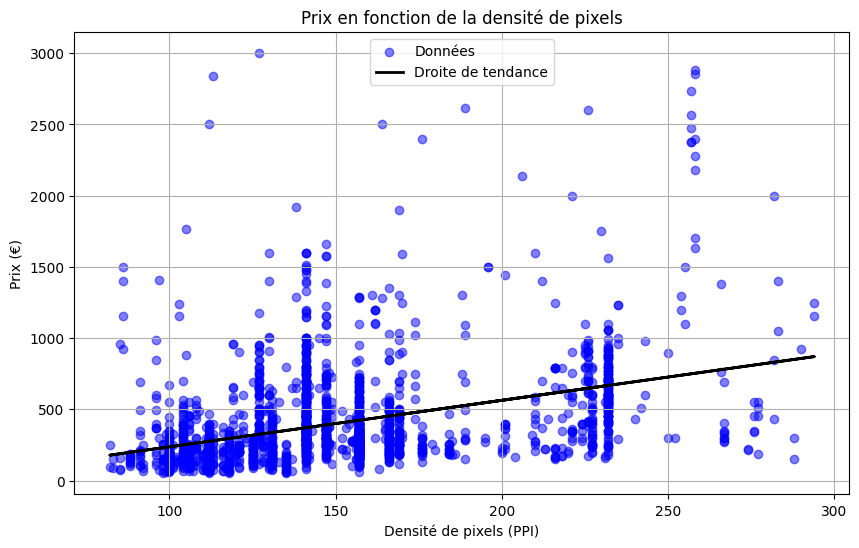

In [17]:
def plot_price(df):
    # Supprimer les lignes avec des valeurs NaN dans 'Prix' ou 'PPI'
    df_clean = df.dropna(subset=['Prix', 'PPI'])
    
    # Extraire les colonnes nécessaires
    x = df_clean['PPI']
    y = df_clean['Prix']
    
    # Calculer les coefficients de la régression linéaire
    coefficients = np.polyfit(x, y, 1)  # Ajuste une droite (polynôme de degré 1)
    trendline = np.poly1d(coefficients)
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', alpha=0.5, label="Données")
    
    # Ajouter la droite de tendance
    plt.plot(x, trendline(x), color='black', linewidth=2, label="Droite de tendance")
    
    # Ajouter des labels et un titre
    plt.title("Prix en fonction de la densité de pixels")
    plt.xlabel("Densité de pixels (PPI)")
    plt.ylabel("Prix (€)")
    plt.legend()
    plt.grid(True)
    
    # Afficher le graphique
    plt.show()
plot_price(df)

La visualisation montre une corrélation positive modérée entre le prix et le PPI. Cela signifie que les ordinateurs portables avec des écrans de meilleure qualité tendent à coûter plus cher. Cette corrélation n'est toutefois pas évidente au vu du graphique. Il serait sans doute pertinent de l'analyser plus en détail avec une régression linéaire plus approfondie. 

Attardons nous maintenant sur la qualité des ordinateurs : 

In [18]:
count = df['Condition'].value_counts()
print(count)

Condition
Occasion         3374
Très bon état     303
État correct      217
Neuf              204
Ouvert            112
Parfait état       67
Name: count, dtype: int64


Étant donné que la majorité des ordinateurs sont dans la catégorie "Occasion" (3209 sur 4033), il semble que l'état général du produit ne soit pas un critère pertinent pour expliquer les variations de prix.

Nous pouvons maintenant passer à l'analyse de la marque. Cette variable nous a semblé pertinente dans la mesure où la marque influence beaucoup la popularité des articles et donc pourrait par la suite influencer leur prix. 

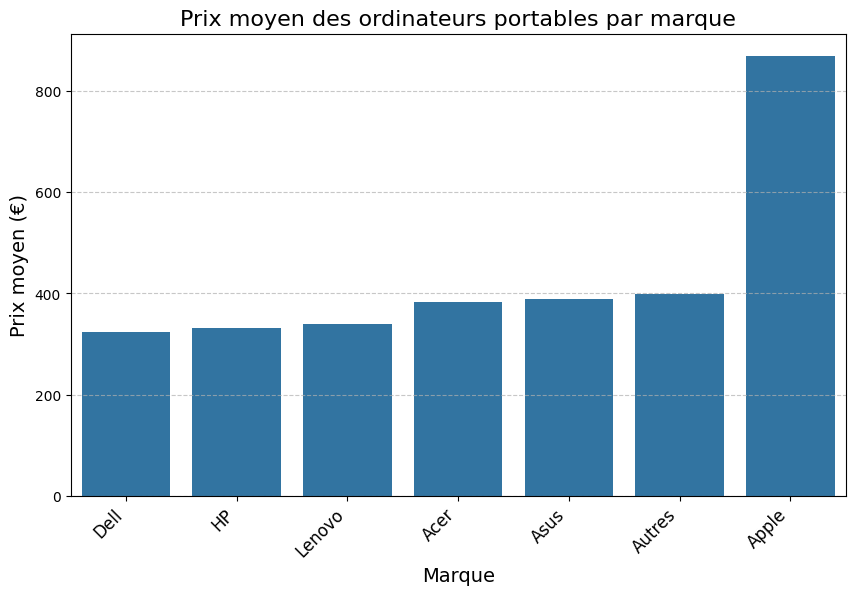

In [19]:
def avgprice_brand(df):
    """
    Calcule et affiche le prix moyen des ordinateurs portables par marque.
    Cette fonction filtre les marques qui représentent moins de 5% du total des marques
    et les regroupe sous l'étiquette 'Autres'
    """
    brand_counts = df['Marque'].value_counts()
    threshold = 0.05 * brand_counts.sum()  # Seuil de 5% pour les marques
    filtered_brands = brand_counts[brand_counts >= threshold].index
    df['Marque'] = df['Marque'].apply(lambda x: x if x in filtered_brands else 'Autres')

    avg_price_by_brand = df.groupby('Marque')['Prix'].mean().sort_values()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values)

    plt.title("Prix moyen des ordinateurs portables par marque", fontsize=16)
    plt.xlabel("Marque", fontsize=14)
    plt.ylabel("Prix moyen (€)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
    
avgprice_brand(df)

L’histogramme montre qu’Apple affiche des prix nettement plus élevés. Néanmoins, cela pourrait s’expliquer par le fait qu’ils produisent des ordinateurs de meilleure qualité ; il serait donc pertinent d’analyser un graphique similaire en comparant des ordinateurs ayant des capacités équivalentes.

Marque
Dell      230
Lenovo    183
HP        159
Apple     136
Autres     83
Acer       16
Asus       14
Name: count, dtype: int64


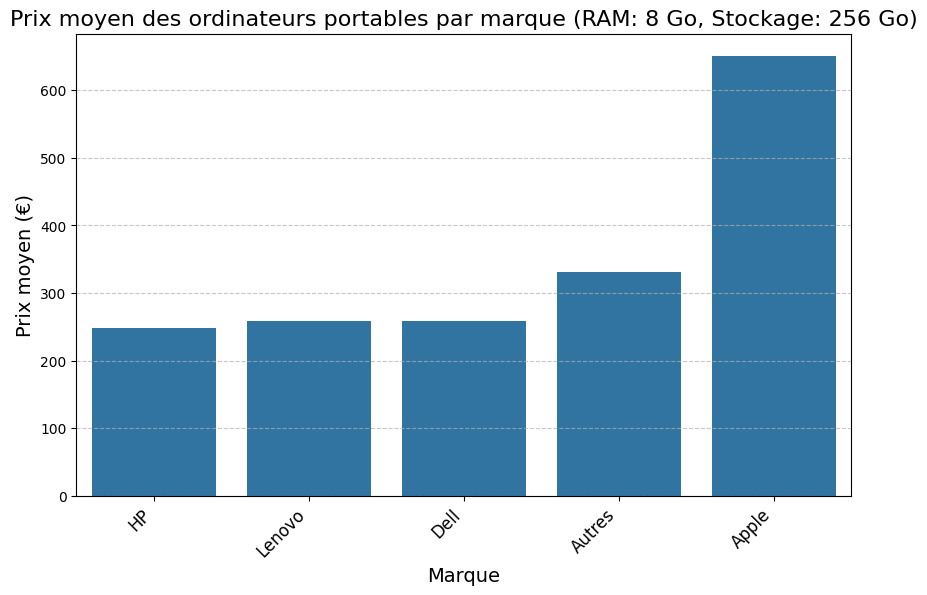

In [20]:
def avgprice_brand2(df):

    # Filtrer les ordinateurs avec RAM de 8 Go et stockage de 256 Go
    filter = df[(df['RAM'] == 8) & (df['Stockage'] == 256)]

    # Calcul des marques représentant au moins 5% des occurrences
    brand_counts = filter['Marque'].value_counts()
    print(brand_counts)
    threshold = 0.05 * brand_counts.sum()  # Seuil de 5% pour les marques
    filtered_brands = brand_counts[brand_counts >= threshold].index
    filter.loc[:, 'Marque'] = filter['Marque'].apply(lambda x: x if x in filtered_brands else 'Autres')

    # Calcul du prix moyen par marque
    avg_price_by_brand = filter.groupby('Marque')['Prix'].mean().sort_values()

    # Création du graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_price_by_brand.index, y=avg_price_by_brand.values)

    plt.title("Prix moyen des ordinateurs portables par marque (RAM: 8 Go, Stockage: 256 Go)", fontsize=16)
    plt.xlabel("Marque", fontsize=14)
    plt.ylabel("Prix moyen (€)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
avgprice_brand2(df)

Nous avons ici choisi de sélectionner des ordinateurs présentant 8Go de RAM et 256Go de Stockage, des ordinateurs présentant donc les mêmes spécificités techniques. Pour autant le résultat reste le même : les ordinateurs Apple domine le marché en termes de prix de vente. Pour expliquer ceci nous pouvons nous pencher un peu plus sur la popularité des marques. 

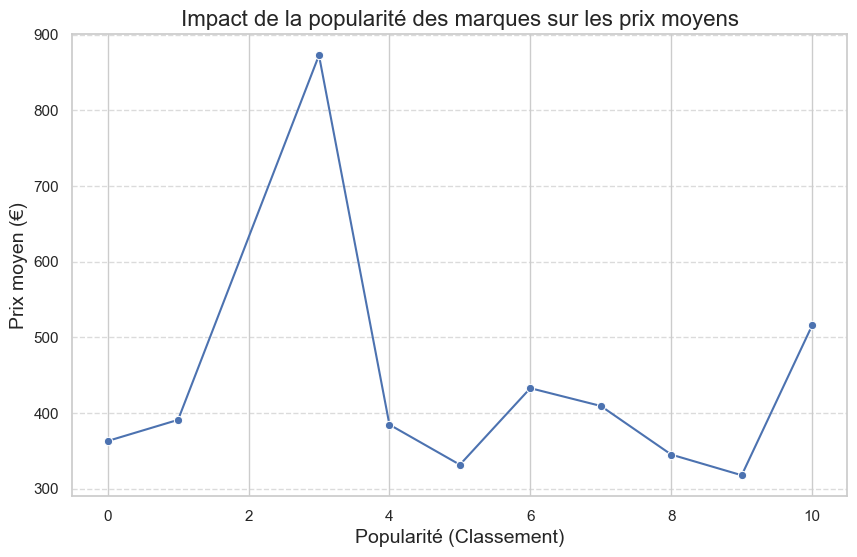

In [42]:
def avg_price_popularity(df):
    popularity = df.groupby('Rang')['Prix'].mean()

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=popularity.index, y=popularity.values, marker='o')

    plt.title("Impact de la popularité des marques sur les prix moyens", fontsize=16)
    plt.xlabel("Popularité (Classement)", fontsize=14)
    plt.ylabel("Prix moyen (€)", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
avg_price_popularity(df)

Nous voyons que la popularité des marques a un réel impact sur les prix des ordinateurs. Ceci sera analysé plus en détail à l'aide de la régression linéaire. 

Il nous reste à observer la temporalité. On peut supposer que la période de l'année à laquelle l'annonce est publiée pourrait avoir un effet sur le prix. 

Nombre d'ordinateurs vendus par mois :
 Mois
1      103
2       64
3      154
4      116
5      127
6      120
7      121
8      144
9      397
10     407
11     720
12    1807
Name: count, dtype: int64


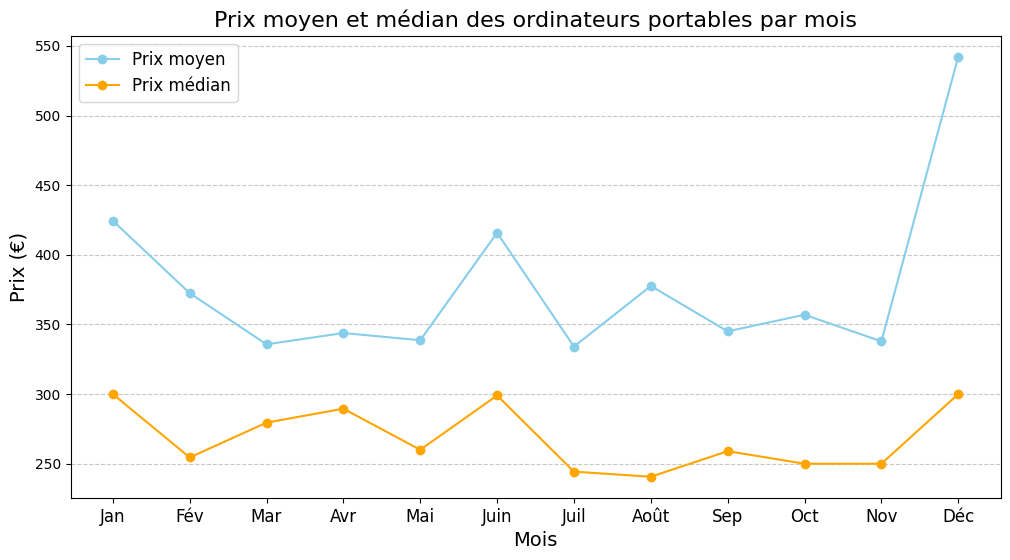

In [22]:
def avg_price_per_month(df):
    # Extraire le mois
    df['Mois'] = df['Date de publication'].dt.month
    
    # Moyenne et médiane des prix par mois
    avg_price_per_month = df.groupby('Mois')['Prix'].mean()
    median_price_per_month = df.groupby('Mois')['Prix'].median()

    # Compter le nombre d'ordinateurs vendus par mois
    count_per_month = df['Mois'].value_counts().sort_index()
    print("Nombre d'ordinateurs vendus par mois :\n", count_per_month)

    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(avg_price_per_month.index, avg_price_per_month.values, marker='o', label='Prix moyen', color='skyblue')
    plt.plot(median_price_per_month.index, median_price_per_month.values, marker='o', label='Prix médian', color='orange')
    plt.title("Prix moyen et médian des ordinateurs portables par mois", fontsize=16)
    plt.xlabel("Mois", fontsize=14)
    plt.ylabel("Prix (€)", fontsize=14)
    plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'], fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
avg_price_per_month(df)

Nous avons choisi d'afficher à la fois le prix moyen par mois et le prix médian. En effet, comme la collecte des données a commencé en décembre, le nombre d'annonces publiées en décembre est largement supérieur à celui des autres mois. Ainsi, la nette supériorité du prix moyen en décembre pourrait s'expliquer par un manque de données pour les autres mois. C'est pourquoi le prix médian apparaît comme une mesure plus pertinente dans cette analyse. Toutefois, la tendance observée avec le prix moyen reste la même : le prix médian en décembre est supérieur à celui des autres mois. 

Une explication possible pourrait être l'approche des fêtes de fin d'année, qui incite les vendeurs à proposer leurs ordinateurs portables à un prix plus élevé, sachant que la demande pour ces produits augmente durant cette période. 
Toutefois, il est possible que nous faisions face à un biais de récolte de données. En effet, les données récoltées représentent uniquement les annonces encore actives et invendues à ce moment-là. Les données sur les ordinateurs vendus lors des mois précédents, sûrement plus compétitifs, ne sont pas disponibles ce qui nous encourage à être prudent sur cette analyse.  

Nous avons réalisé ces graphiques car nous pensions que la popularité des marques dans les classements globaux (représentée par leur rang) pourrait influencer directement la popularité des articles correspondants sur eBay (mesurée par le coefficient de popularité). L’idée était de vérifier si les marques bien classées globalement, comme Apple ou Asus, se traduisaient également par une popularité élevée auprès des acheteurs sur eBay. Pour explorer cette hypothèse, nous avons d’abord visualisé la popularité des marques à travers un histogramme, avant d’étudier leur lien avec les rangs dans un graphique relationnel.

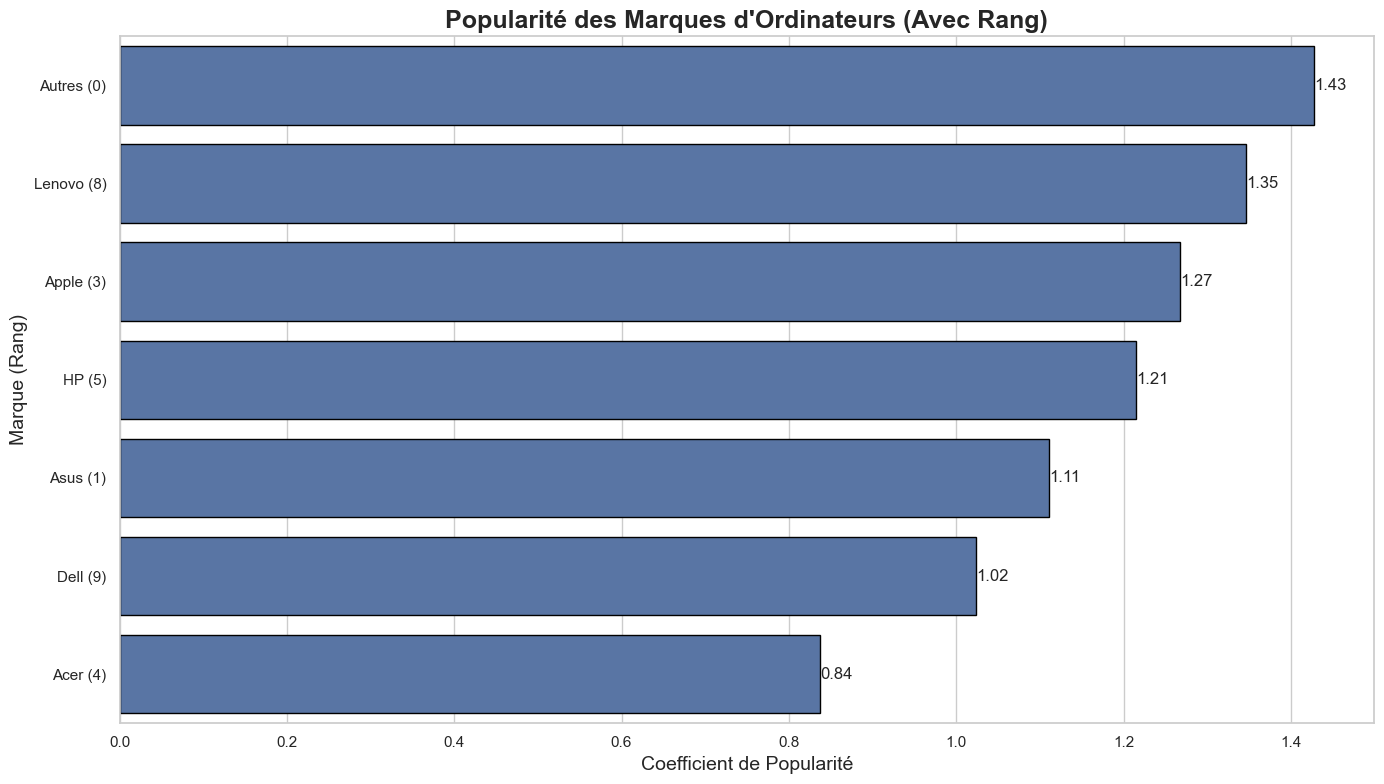

In [24]:
# Filtrer les marques ayant un coefficient supérieur à 0.1
filtered_df = df[df['Coefficient'] > 0.1]

# Extraire les marques uniques avec leurs rangs (en prenant le premier rang pour chaque marque)
unique_brands = (
    filtered_df.groupby('Marque')
    .agg(
        Rang=('Rang', 'first'),  # Prendre le premier rang trouvé
        Coefficient=('Coefficient', 'mean')  # Moyenne des coefficients
    )
    .reset_index()
)

# Ajouter les rangs entre parenthèses aux noms des marques
unique_brands['Label'] = unique_brands['Marque'] + ' (' + unique_brands['Rang'].astype(str) + ')'

# Trier par coefficient pour un affichage ordonné
unique_brands = unique_brands.sort_values(by='Coefficient', ascending=False)

# Définir le style
sns.set_theme(style="whitegrid")

# Créer une figure
plt.figure(figsize=(14, 8))

# Graphique en barres
ax = sns.barplot(
    data=unique_brands, 
    x='Coefficient', 
    y='Label',  # Utiliser les labels contenant les rangs entre parenthèses
    edgecolor="black"
)

# Ajouter des titres et des labels
ax.set_title('Popularité des Marques d\'Ordinateurs (Avec Rang)', fontsize=18, weight='bold')
ax.set_xlabel('Coefficient de Popularité', fontsize=14)
ax.set_ylabel('Marque (Rang)', fontsize=14)

# Ajouter les valeurs sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=12)

# Optimiser l'affichage
plt.tight_layout()
plt.show()

L’histogramme présente la popularité moyenne des marques sur eBay, mesurée par le coefficient de popularité. On y observe que certaines marques comme Apple et Lenovo dominent en termes de coefficients, ce qui suggère une forte demande ou un attrait particulier pour leurs produits. En revanche, des marques comme Dell ou Acer sont moins populaires selon cette métrique. Cet histogramme met en évidence une hiérarchie dans les préférences des acheteurs sur eBay, mais il ne permet pas encore de dire si cette popularité correspond à celle des marques dans les classements globaux.


L’histogramme a été réalisé en premier pour fournir une vue d’ensemble de la popularité des marques en fonction des coefficients moyens calculés à partir des articles vendus sur eBay. Cette visualisation permet d’identifier rapidement quelles marques sont les plus populaires auprès des acheteurs. Cependant, cette approche descriptive ne suffit pas à expliquer si cette popularité reflète réellement les classements globaux des marques sur des sites externes. C’est pourquoi un second graphique a été élaboré, visant à explorer directement la relation entre le rang des marques (leur popularité perçue globalement) et leur popularité réelle mesurée sur eBay. Ce deuxième graphique complète donc l’analyse en répondant à la question : « Les marques bien classées sont-elles réellement populaires sur eBay ? ». Cette progression logique permet de passer d’une analyse descriptive à une analyse relationnelle plus approfondie.

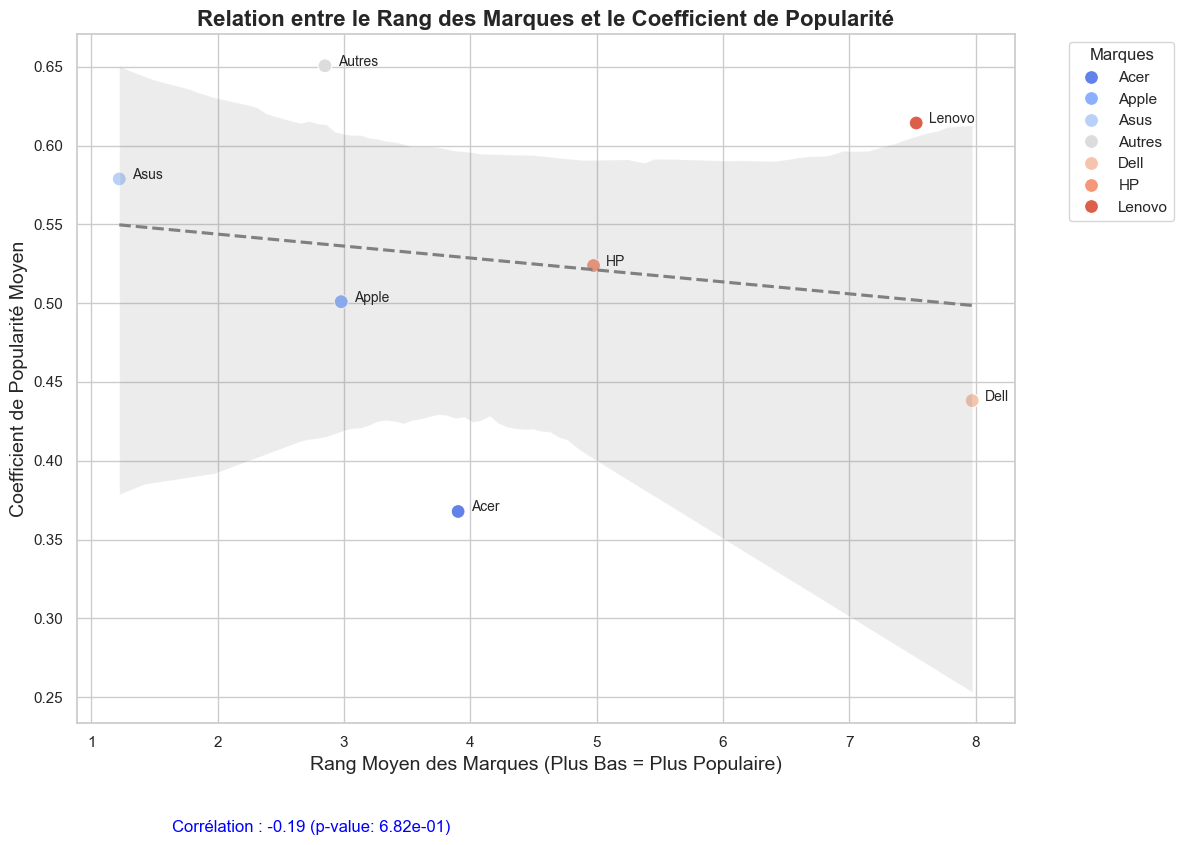

In [25]:
from scipy.stats import pearsonr

# Remplacer les valeurs nulles par des zéros pour éviter les exclusions
df['Rang'] = df['Rang'].fillna(0)
df['Coefficient'] = df['Coefficient'].fillna(0)

# Calculer les moyennes par marque
brand_stats = df.groupby('Marque').agg(
    Avg_Rang=('Rang', 'mean'), 
    Avg_Coefficient=('Coefficient', 'mean')
).reset_index()

# Calculer la corrélation
correlation, p_value = pearsonr(brand_stats['Avg_Rang'], brand_stats['Avg_Coefficient'])

# Définir le style
sns.set_theme(style="whitegrid")

# Créer la figure
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=brand_stats, 
    x='Avg_Rang', 
    y='Avg_Coefficient', 
    hue='Marque', 
    palette='coolwarm', 
    s=100
)

# Ajouter une ligne de tendance
sns.regplot(
    data=brand_stats, 
    x='Avg_Rang', 
    y='Avg_Coefficient', 
    scatter=False, 
    color='gray', 
    line_kws={"linestyle": "dashed"}
)

# Ajouter des annotations
for i, row in brand_stats.iterrows():
    plt.text(
        row['Avg_Rang'] + 0.1, 
        row['Avg_Coefficient'], 
        row['Marque'], 
        fontsize=10
    )

# Ajouter des titres et labels
plt.title('Relation entre le Rang des Marques et le Coefficient de Popularité', fontsize=16, weight='bold')
plt.xlabel('Rang Moyen des Marques (Plus Bas = Plus Populaire)', fontsize=14)
plt.ylabel('Coefficient de Popularité Moyen', fontsize=14)
plt.legend(title="Marques", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Afficher la corrélation
plt.figtext(0.15, -0.05, f"Corrélation : {correlation:.2f} (p-value: {p_value:.2e})", fontsize=12, color="blue")

plt.show()

Le deuxième graphique explore la relation entre le rang global des marques (basé sur les classements externes) et leur popularité sur eBay. Contrairement à ce que nous avions supposé, il n’existe pas de lien évident entre ces deux variables : la corrélation calculée est proche de zéro, indiquant une absence de relation significative. Par exemple, des marques comme Asus et Apple, bien classées globalement (rang faible), affichent des coefficients de popularité sur eBay relativement similaires à ceux de marques comme Lenovo ou HP, moins bien classées globalement. Cela suggère que la popularité des articles sur eBay dépend d’autres facteurs (prix, disponibilité, modèles spécifiques, etc.) plutôt que du rang global des marques.

## **5. Modélisation**

Le modèle que nous avons choisi dans le cadre de ce projet est le modèle de régression linéaire. Nous avons choisi ce modèle car il est simple à comprendre et à interpréter, et il est également rapide à entraîner. Nous allons entraîner un modèle de régression linéaire pour prédire le prix des ordinateurs portables en fonction de certaines de leurs caractéristiques.

Nous utiliserons la bibliothèque *scikit-learn* afin de coder le modèle. 

### **5.1 Prétraitement des données**

#### 5.1.1 Encodage des colonnes catégoriques

Nous commençons par encoder les colonnes catégoriques, à savoir **Marque**, **Couleur** et **Condition**. Pour ce faire, nous transformons chaque catégorie en une variable binaire (*dummy*). Cette méthode permet d'identifier l'effet de chaque catégorie sans introduire de relation ordinale entre elles, contrairement à un encodage numérique simple tel que celui de la colonne **Rang**. 

In [26]:
df = pd.get_dummies(df, columns=['Marque', 'Condition','Couleur'], drop_first=True)

Pour la colonne Date de publication, nous avons observé que l'effet sur le prix dépend principalement de si l'annonce a été publiée en décembre. Par conséquent, nous avons créé une variable binaire Décembre qui prend la valeur 1 si l'annonce a été publiée en décembre, et 0 sinon.

In [27]:
df['Month'] = pd.to_datetime(df['Date de publication']).dt.month
df['December'] = df['Month'].apply(lambda x: 1 if x == 12 else 0)

On supprime ensuite les colonnes inutiles.

In [28]:
df = df.drop(columns=['ID','Date de publication','Month'])

#### 5.1.2 Gestion des valeurs manquantes

Notre première approche a été de remplacer les valeurs manquantes pour les colonnes numériques par la médiane des valeurs. Mais nous avons remarqué que la prédiction était peu satisfaisante ($R^2 < 0.5$). Nous avons alors chercher à mieux gérer les valeurs manquantes.  

Après quelques recherches, nous avons opté pour l'imputation **KNN (K-Nearest Neighbors)**. Contrairement à l'imputation par la médiane, qui remplace les valeurs manquantes par une valeur fixe, l'imputation KNN utilise les valeurs des k voisins les plus proches pour estimer les valeurs manquantes. Cette méthode est souvent plus précise car elle prend en compte la similarité entre les observations. En utilisant les k voisins les plus proches, l'imputation KNN peut capturer des relations plus complexes dans les données, ce qui peut améliorer les performances du modèle. 

In [29]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

Pour préparer les données pour le modèle de machine learning, nous avons défini les variables explicatives (*features*) et la variable cible (*target*). 

Les features sont toutes les colonnes du DataFrame *df_imputed* à l'exception de la colonne **Prix**. La variable cible, y, est la colonne **Prix** transformée logarithmiquement. Cette transformation logarithmique est appliquée pour normaliser les données et réduire l'effet des valeurs extrêmes, ce qui améliore la qualité du modèle d'après les tests que nous avons effectué.



In [30]:
X = df_imputed.drop(columns=['Prix'])
y = np.log(df_imputed['Prix'])

#### 5.1.3 Normalisation des valeurs

Pour la normalisation des valeurs de notre jeu de données, nous avons utilisé la classe StandardScaler de la bibliothèque scikit-learn. La normalisation est une étape importante dans le prétraitement des données, surtout pour les algorithmes de machine learning sensibles à l'échelle des données. 

Cela nous a permis de standardiser les caractéristiques en supprimant la moyenne et en les redimensionnant à l'unité de variance. Ensuite, nous avons ajusté et transformé les données. Le résultat, *X_scaled*, est un tableau numpy contenant les caractéristiques normalisées, prêtes à être utilisées pour l'entraînement du modèle.

In [31]:
from sklearn.preprocessing import StandardScaler

# Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 5.1.4 Séparation des données en ensembles d'entraînement et de test

La séparation des données en ensembles d'entraînement et de test est essentielle pour évaluer objectivement la performance d'un modèle de machine learning. Nous avons choisi un ensemble d'entraînement qui représente 80% des données, il est utilisé pour entraîner le modèle, tandis que notre ensemble de test, les 20% restants, permet de vérifier la capacité du modèle à généraliser sur des données non vues. 

Cette pratique aide à prévenir le surajustement (*Overfitting*), où le modèle apprend trop bien les détails des données d'entraînement au détriment de sa performance sur de nouvelles données. En évaluant le modèle sur l'ensemble de test, nous pouvons nous assurer qu'il performe bien avant de le déployer en production.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 5.2 **Application du modèle**

#### 5.2.1 Exécution du modèle

Nous avons entraîné le modèle en utilisant les données d'entraînement avec la méthode fit *(X_train, y_train)*. Cette méthode ajuste le modèle aux données d'entraînement, apprenant ainsi les relations entre les caractéristiques (*features*) et la variable cible (*target*).

Après l'entraînement, nous avons utilisé le modèle pour faire des prédictions sur l'ensemble de test. Les prédictions, stockées dans *y_pred*, représentent les valeurs prévues par le modèle pour les données de test.

Pour comprendre l'importance de chaque caractéristique dans le modèle, nous avons affiché les coefficients du modèle. Cela nous permet de voir l'impact de chaque caractéristique sur la variable cible.

Enfin, nous avons évalué la performance du modèle en utilisant plusieurs métriques:

* Le $R²$ **Score** mesure la proportion de la variance de la variable cible expliquée par les caractéristiques.  

* Le **$MAE$ (Mean Absolute Error)** mesure l'erreur moyenne absolue entre les prédictions et les valeurs réelles.  

* Le **$RMSE$ (Root Mean Squared Error)** mesure l'erreur quadratique moyenne entre les prédictions et les valeurs réelles. Ces métriques nous donnent une idée de la précision et de la fiabilité du modèle.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialisation du modèle
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Afficher les coefficients du modèle
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients.round(3))

# Évaluation du modèle
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

                         Coefficient
RAM                            0.247
Stockage                       0.128
Taille écran                   0.097
Rang                          -0.105
Coefficient                   -0.024
PPI                            0.292
Mois                          -0.051
Marque_Apple                   0.202
Marque_Asus                    0.007
Marque_Autres                  0.060
Marque_Dell                    0.099
Marque_HP                      0.039
Marque_Lenovo                  0.097
Condition_Occasion            -0.233
Condition_Ouvert               0.002
Condition_Parfait état        -0.076
Condition_Très bon état       -0.137
Condition_État correct        -0.140
Couleur_blanc                 -0.032
Couleur_bleu                   0.015
Couleur_gris                   0.068
Couleur_marron                -0.029
Couleur_noir                   0.008
Couleur_rose                   0.020
Couleur_rouge                 -0.012
Couleur_vert                   0.004
D

#### 5.2.2 Interprétation des résultats

##### 1. **Caractéristiques techniques**
Les caractéristiques techniques comme la **RAM** ($0.247$) et le **PPI** ($0.292$) restent les plus influentes dans la détermination des prix, ce qui souligne leur importance perçue par les consommateurs. Le **Stockage** ($0.128$) et la **Taille de l’écran** ($0.097$) ont un impact moindre, mais ils contribuent également positivement au prix, reflétant leurs rôles dans la valeur perçue.

##### 2. **Popularité des marques et des produits**
**Rang** ($-0.105$) : Les marques moins populaires dans les classements ont tendance à afficher des prix plus bas. Ce résultat est intuitif, car une moindre popularité peut être associée à une perception de qualité ou de prestige inférieure. 

**Coefficient de popularité** ($-0.024$) : Les produits avec des indices de popularité plus élevés ne bénéficient que faiblement d'une prime sur le prix. Cette faible corrélation peut s’expliquer par une saturation du marché : les consommateurs achètent des produits populaires sans nécessairement payer une prime importante.

##### 3. **Effet des marques**
L'effet des marques reflète leur positionnement :

*Apple* ($0.202$) reste la marque qui influence le plus fortement le prix, soulignant son prestige et son image haut de gamme.
Les autres marques comme $Dell* ($0.099$), *Lenovo* ($0.097$) et *HP* ($0.039$) montrent une influence positive mais modérée, tandis que *Asus* ($0.007$) reste quasi neutre.  
*Marques autres* ($0.060$) : Ce groupe montre que même des marques moins connues peuvent maintenir un prix relativement compétitif.

##### 4. **Conditions des produits**
Les coefficients pour les conditions sont cohérents avec les attentes du marché :

Les ordinateurs occasion ($-0.233$), état correct ($-0.140$) ou très bon état ($-0.137$) subissent des décotes importantes par rapport au neuf.
Les produits en parfait état ($-0.076$) ou ouvert ($0.002$) montrent une décote plus faible, confirmant que l’état proche du neuf est perçu positivement.

##### 5. **Variables temporelles et esthétiques**
**Mois** ($-0.051$) : Une légère baisse des prix au fil du temps est observée, probablement liée à la dépréciation technologique et à la sortie de nouveaux modèles.

**Couleurs** : Les coefficients des couleurs (par exemple, gris ($0.068$), blanc ($-0.032$)) montrent des impacts marginaux, ce qui suggère que l’esthétique a une influence très faible sur le prix.

##### **Qualité du modèle et conclusion**
$R²$ **Score** ($0.59$) indique que 59 % de la variance des prix est expliquée par le modèle.  
Les métriques d’erreur ($MAE : 0.38$ et $RMSE : 0.25$) confirment une bonne précision globale.

En conclusion, le prix des ordinateurs portables est majoritairement influencé par leurs caractéristiques techniques et la notoriété des marques. La popularité des articles et le rang des marques jouent un rôle négatif mais relativement limité, indiquant que les consommateurs se concentrent davantage sur la valeur intrinsèque du produit et la réputation globale de la marque. Les conditions des produits ont une importance capitale, tandis que les aspects esthétiques et temporels restent secondaires.